### Neale Ellyson
## MSE 608 - Final Project

### Initialize
Import...
 - HOOMD and the molecular dynamics package for creating the simulations
 - NumPy for math and array functions
 - ex_render for visualizing simulation boxes
 - Matplotlib for plotting, and lastly

In [43]:
import hoomd
import hoomd.md
import numpy
import ex_render
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Functions
Size: Small function that creates the initial position vectors of polymers and their shape
For example, for N = 10, the positions are lined up along the length of the simulation box and the bondgroup connects particles 0-9 to eachother in a single line. 

In [44]:
def size(N):
    line = numpy.linspace(-(N//2-.5),(N//2-.5),num=N)
    position = numpy.insert(numpy.zeros((N,2)), 0, line, axis=1)
    a = numpy.repeat(numpy.arange(N),2)
    bondgroup = a[1:-1].reshape(len(a[1:-1])//2,2)
    return position,bondgroup

Run: Runs a molecular dynamics simulation using...
 - repulsion parameter, $a_{AB}$
 - length of the polymers, $N$
 - volume fraction of B, $\phi_B$
 - `position` and `bondgroups` provided from the previous function
 - temperature of the system in energy units, $kT$
 - a coupling constant for our integrator thermostat, $\tau$
 - frequency when the system quantities are written to the log files, defined as `period`
 - and lastly the time to run the simulation, defined as `tsteps`
 
The simulation defines a box of $N\times N\times N$ dimensions containing polymers made up of 'A' and 'B' particles, with varying fractions of B. The simulation uses dissipative particle dynamics (DPD) where particles within a certain radius are dictated by a summation of interaction, dissipative, and random forces. The interaction forces can be adjusted through the $a_{AB}$ parameter. 

In [45]:
def run(aAB,N,phiB,position,bondgroup,kT,tau,period,tsteps):
    fAN = int((1-phiB)*N)
    hoomd.context.initialize("");
    snapshot = hoomd.data.make_snapshot(N=N, # Number of atoms in a particle
                                        box=hoomd.data.boxdim(Lx=N, Ly=0.5, Lz=0.5),
                                        particle_types=['A', 'B'],
                                        bond_types=['polymer']); # Single bond type
    snapshot.particles.position[:] = position
# Blue particles = A
    snapshot.particles.typeid[0:(fAN)]=0;  
# Orange particles = B
    snapshot.particles.typeid[(fAN):N]=1;
    snapshot.bonds.resize(N-1);
    snapshot.bonds.group[:] = bondgroup
# Makes simulation box equal across the L dimensions
    snapshot.replicate(1,2*N,2*N); 
    hoomd.init.read_snapshot(snapshot);
# Defining the neighbor list acceleration structure to find neighboring particles efficiently
    nl = hoomd.md.nlist.cell(); 
    dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=kT, seed=1);
    dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0); # Interations between like 'A' particles
    dpd.pair_coeff.set('A', 'B', A=aAB, gamma = 1.0);  # Interations between 'A' & 'B' particles
    dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0); # Interations between like 'B' particles
# Allows particles to interact with each other dictated by previous 'A' parameter
    nl.reset_exclusions(exclusions = []); 
# Apply harmonic bonds between the directly bonded particles
    harmonic = hoomd.md.bond.harmonic();  
    harmonic.bond_coeff.set('polymer', k=100.0, r0=1); # r0 = 1 means the particles are spaced and form expected morphologies
    hoomd.md.integrate.mode_standard(dt=0.005);
    all = hoomd.group.all();
# The integrator defines the equations of motion that govern the system of particles, given the current configuration 
# of the particles and the net force from all potentials
# NVT: performs constant volume, constant temperature simulations using the Nosé-Hoover thermostat
    integrator = hoomd.md.integrate.nvt(group=all,kT=kT,tau=tau);
    integrator.randomize_velocities(seed=42)
# Periodically log the potential energy, kinetic energy, temperature, and time elapsed of the system to a text file.
    hoomd.analyze.log(filename="logs/rep-"+str(aAB)+"frac-"+str(phiB)+".log",
                      quantities=['potential_energy','kinetic_energy','temperature','time'],
                      period=period ,
                      overwrite=True);
# Writes simulation snapshots in the GSD format
    hoomd.dump.gsd("gsds/traj-rep-"+str(aAB)+"frac-"+str(phiB)+".gsd", period=tsteps/10 , group=all, overwrite=True);
# Let's run this baby!
    hoomd.run(tsteps);
# Return data from function that will go into a dictionary
    data = numpy.genfromtxt(fname="logs/rep-"+str(aAB)+"frac-"+str(phiB)+".log", skip_header=True);
    return data

EQRun: Takes the trajectory file of the initialized molecular dynamics simulation and runs it from that last moment to allow the system to complete equilibration. This can be confirmed from the potential energy plots. 

Again using...
 - repulsion parameter, $a_{AB}$
 - temperature of the system in energy units, $kT$
 - a coupling constant for our integrator thermostat, $\tau$
 - frequency when the system quantities are written to the log files, defined as `period`
 - and lastly the time to run the simulation, defined as `tsteps`
 
This run is consistent with the previous simulation function using DPD, the same particle interaction parameters, bond interations, integration scheme and writes out equilibriated log and gsd files. 

In [46]:
def EQrun(aAB,kT,tau,period,tsteps):
    hoomd.context.initialize("");
# Read in the initialized simulation
    system = hoomd.init.read_gsd("gsds/traj-rep-"+str(aAB)+"frac-"+str(phiB)+".gsd", frame=-1, time_step=0)
# Defining the neighbor list acceleration structure to find neighboring particles efficiently
    nl = hoomd.md.nlist.cell();
    dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=kT, seed=1); # NOT Dissipative Particle Dynamics, LJ
    dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0); # Interations between like 'A' particles
    dpd.pair_coeff.set('A', 'B', A=aAB, gamma = 1.0);  # Interations between 'A' & 'B' particles
    dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0); # Interations between like 'B' particles
    nl.reset_exclusions(exclusions = []);
# Apply harmonic bonds between the directly bonded particles
    harmonic = hoomd.md.bond.harmonic();
    harmonic.bond_coeff.set('polymer', k=100.0, r0=1);
    hoomd.md.integrate.mode_standard(dt=0.005);
    all = hoomd.group.all();
# The integrator defines the equations of motion that govern the system of particles, given the current configuration 
# of the particles and the net force from all potentials
# NVT: performs constant volume, constant temperature simulations using the Nosé-Hoover thermostat
    integrator = hoomd.md.integrate.nvt(group=all,kT=kT,tau=tau);
    integrator.randomize_velocities(seed=42)
# Periodically log the potential energy, kinetic energy, temperature, and time elapsed of the system to a text file.
    hoomd.analyze.log(filename="logs/EQ-rep-"+str(aAB)+"frac-"+str(phiB)+".log",
                      quantities=['potential_energy','kinetic_energy','temperature','time'],
                      period=period ,
                      overwrite=True);
# Writes simulation snapshots in the GSD format
    hoomd.dump.gsd("gsds/EQtraj-rep-"+str(aAB)+"frac-"+str(phiB)+".gsd", period=tsteps/10 , group=all, overwrite=True);
# Let's run this baby!
    hoomd.run(tsteps);
# Return data from function that will go into a dictionary
    data = numpy.genfromtxt(fname="logs/EQ-rep-"+str(aAB)+"frac-"+str(phiB)+".log", skip_header=True);
    return data

In [47]:
# Initialize dictionaries for storing sets of data
fractions = {} # With keys of phiB
data = {}      # With keys of aAB
EQfrac = {}    # With keys of phiB
EQdata = {}    # With keys of aAB

# Defining phiB & aAB, respectively, for our simulation loop
VolFrac = [0.5]  # numpy.arange(0.1,0.6,0.1) # Our x-axis spread
Repulsion = [45] # numpy.arange(25,70,5)     # Our y axis spread

# Define constant values for our simulation, not changed within the loop
N = 10 
kT = 1 
tau = 0.1
period = 100
tsteps = 1e4
start = time.time()
for aAB in Repulsion:
    position,bondgroup = size(N)
    onerun = []
    oneEQrun = []
    for phiB in VolFrac:
        print("\n Starting run with a repulsion parameter of ",aAB,"at a fraction of", phiB,"\n")
        fractions[phiB] = run(aAB,N,phiB,position,bondgroup,kT,tau,period,tsteps)
        onerun.append(fractions[phiB])
        data[aAB] =  numpy.array(onerun)    # Nested dictionary of phiB within aAB
        print("\n Starting equilibrium run with a repulsion parameter of ",aAB,"at a fraction of", phiB,"\n")
        EQfrac[phiB] = EQrun(aAB,kT,tau,period,tsteps)
        oneEQrun.append(EQfrac[phiB])
        EQdata[aAB] = numpy.array(oneEQrun) # Nested dictionary of phiB within aAB
        
finish = time.time()
print('This took',(finish-start)/60,'minutes, or',(finish-start)/60/60,'hours')


 Starting run with a repulsion parameter of  45 at a fraction of 0.5 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1975 / 10000 | TPS 197.48 | ETA 00:00:40

 Starting equilibrium run with a repulsion parameter of  45 at a fraction of 0.5 



ValueError: too many values to unpack (expected 2)

Let's calculate $\chi$!
$$ \chi = \frac{2\alpha(a_{AB}-a_{AA})(\rho_A +\rho_B)}{k_BT}$$
From Groot \& Warren: $ \alpha = 0.101 \pm  0.001$

In [52]:
def chiN(Repulsion):
    dens = 1/(4/3*numpy.pi*0.5**3) # pA + pB, where particles have mass & diameter of 1 and are a sphere
    alpha = 0.101
    aAA = 25
    chi_N = []
    for aAB in Repulsion:
        chi_N.append(2*alpha*(aAB-aAA)*dens*N/kT)
    return chi_N

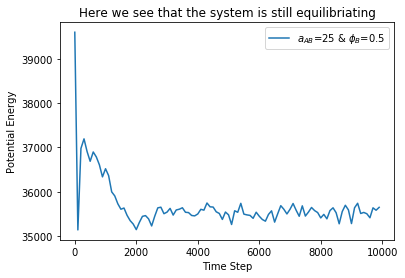

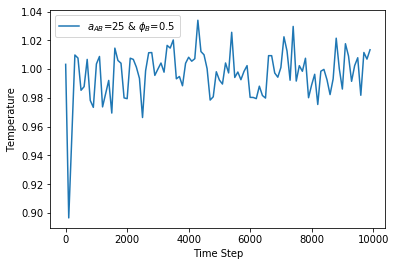

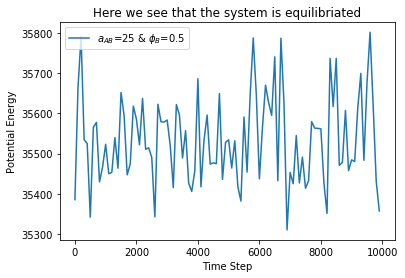

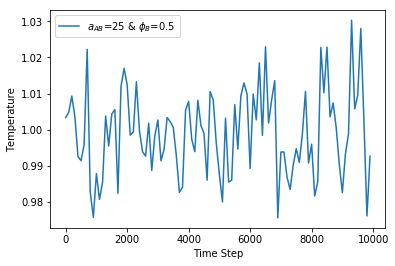

In [57]:
aAB = 25
fA = 0.5
# Initialized system that equilibriating
data = numpy.loadtxt("logs/rep-"+str(aAB)+"frac-"+str(fA)+".log",skiprows = 1)

TimeStep = data[:,0]
PotentialEnergy = data[:,1]+data[:,2]
Temperature = data[:,3]

plt.figure()
plt.plot(TimeStep,PotentialEnergy,label="$a_{AB}$"+f"={aAB} &"" $\phi_{B}$"+f"={phiB}")
plt.title("Here we see that the system is still equilibriating")
plt.ylabel("Potential Energy")
plt.xlabel('Time Step')
plt.legend()

plt.figure()
plt.plot(TimeStep,Temperature,label = "$a_{AB}$"+f"={aAB} &"" $\phi_{B}$"+f"={phiB}")
plt.ylabel("Temperature")
plt.xlabel('Time Step')
plt.legend()

# Equilibriated system
data = numpy.loadtxt("logs/EQ-rep-"+str(aAB)+"frac-"+str(fA)+".log",skiprows = 1)

TimeStep = data[:,0]
PotentialEnergy = data[:,1]+data[:,2]
Temperature = data[:,3]

plt.figure()
plt.plot(TimeStep,PotentialEnergy,label="$a_{AB}$"+f"={aAB} &"" $\phi_{B}$"+f"={phiB}")
plt.title("Here we see that the system is equilibriated")
plt.ylabel("Potential Energy")
plt.xlabel('Time Step')
plt.legend()

plt.figure()
plt.plot(TimeStep,Temperature,label = "$a_{AB}$"+f"={aAB} &"" $\phi_{B}$"+f"={phiB}")
plt.ylabel("Temperature")
plt.xlabel('Time Step')
plt.legend()
plt.show()

# Phase Diagram!

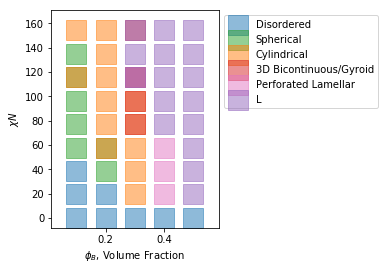

In [58]:
plt.figure(figsize=(3,4))
xD = [0.1, 0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5]
yD = [25, 30, 35, 25, 30, 25, 25, 25]
plt.scatter(xD,chiN(yD),label="Disordered", color="tab:blue", alpha=0.5, marker="s", s = 400)
xS = [0.1,0.1,0.1,0.1,0.1,0.2,0.2]
yS = [40, 45, 50, 55, 60, 35,40]
plt.scatter(xS,chiN(yS),label="Spherical", color="tab:green", alpha=0.5, marker="s", s = 400)
xC = [0.1,0.1,0.2,0.2,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.3,0.3,0.3]
yC = [55, 65, 40, 45, 50, 55, 60, 65, 30, 35, 40, 45, 50, 55]
plt.scatter(xC,chiN(yC),label="Cylindrical", color="tab:orange", alpha=0.5, marker="s", s = 400)
x3D = [0.3,0.3,0.3,0.3]
y3D = [45, 50, 55, 65]
plt.scatter(x3D,chiN(y3D),label="3D Bicontinuous/Gyroid", color="tab:red", alpha=0.5, marker="s", s = 400)
xPL = [0.3,0.4,0.4,0.4]
yPL = [55, 30, 35, 40]
plt.scatter(xPL,chiN(yPL),label="Perforated Lamellar", color="tab:pink", alpha=0.5, marker="s", s = 400)
xL = [0.3,0.3,0.3,0.4,0.4,0.4,0.4,0.4,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
yL = [55, 60, 65, 45, 50, 55, 60, 65, 30, 35, 40, 45, 50, 55, 60, 65]
plt.scatter(xL,chiN(yL),label="L", color="tab:purple", alpha=0.5, marker="s", s = 400)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.ylabel("$\chi N$")
plt.xlabel("$\phi_B$, Volume Fraction")
plt.show()

Here we have the phase diagram from Phase Diagrams of Block Copolymer Melts by Dissipativs Particle Dynamics by Alexey A. Gavrilov, Yaroslav V. Kudryavtsev, and Alexander V. Chertovich
<img src="DPD Phase Diagram.png">